In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

# Define your models
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier





In [3]:
# Load and clean data
df = pd.read_csv("players_data.csv", encoding='latin1')

In [4]:
# Check how many rows have any missing trait values
trait_cols = ['Trait_Main1', 'Trait_Main2', 'Trait_Sub1', 'Trait_Sub2']

# Count rows with any missing trait
missing_trait_rows = df[trait_cols].isnull().any(axis=1).sum()

# Count total rows before dropping
total_rows_before = len(df)

# Calculate filled vs missing trait ratios
print(f"Total rows before dropping: {total_rows_before}")
print(f"Rows with missing traits: {missing_trait_rows} ({(missing_trait_rows / total_rows_before):.2%})")
print(f"Rows with all traits filled: {total_rows_before - missing_trait_rows} ({((total_rows_before - missing_trait_rows) / total_rows_before):.2%})")


Total rows before dropping: 311265
Rows with missing traits: 41064 (13.19%)
Rows with all traits filled: 270201 (86.81%)


In [5]:
#clean dataset
df = df.drop_duplicates()
df.dropna(subset=['character', 'gameId', 'gameRank'], inplace=True)
df.fillna('Unknown', inplace=True)

In [6]:
#Define win as gameRank == 1
df['win'] = df.groupby('gameId')['gameRank'].rank().apply(lambda x: 1 if x <= 3 else 0)




In [7]:
#Calculate historical win rate for each character
win_rate = df.groupby('character')['win'].mean()



In [8]:
# Calculate average stats for each character (for use when only the character name is provided)
average_stats = df.groupby('character')[['Kill', 'Death', 'Assist', 'Dmg_Player']].mean()



In [9]:
#Features and target
X = df[['character', 'Kill', 'Death', 'Assist', 'Dmg_Player']]
y = df['win']



In [10]:
#Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)



In [11]:
preprocessor = ColumnTransformer(transformers=[
    ('char', OneHotEncoder(handle_unknown='ignore'), ['character']),
    ('num', StandardScaler(), ['Kill', 'Death', 'Assist', 'Dmg_Player'])  # Add this line
], remainder='passthrough')


In [ ]:
models = {
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "SVC": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Extra Trees": ExtraTreesClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(random_state=42)
}

# This dictionary will hold the evaluation results for each model
results = {}

for name, model in models.items():
    print(f"Evaluating {name}...")
    # Define pipeline with the preprocessor and model
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    
    # Perform cross-validation to evaluate the model
    scores = cross_validate(
        pipeline,
        X_train,
        y_train,
        cv=5,
        scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'],
        return_train_score=False
    )
    
    # Store the results for the current model
    results[name] = {
        'accuracy': (scores['test_accuracy'].mean(), scores['test_accuracy'].std()),
        'precision': (scores['test_precision_macro'].mean(), scores['test_precision_macro'].std()),
        'recall': (scores['test_recall_macro'].mean(), scores['test_recall_macro'].std()),
        'f1': (scores['test_f1_macro'].mean(), scores['test_f1_macro'].std())
    }

# Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame(results).T.sort_values(by='f1', ascending=False)

# Split the means and standard deviations into separate columns for each metric
results_df[['accuracy_mean', 'accuracy_std']] = pd.DataFrame(results_df['accuracy'].to_list(), index=results_df.index)
results_df[['precision_mean', 'precision_std']] = pd.DataFrame(results_df['precision'].to_list(), index=results_df.index)
results_df[['recall_mean', 'recall_std']] = pd.DataFrame(results_df['recall'].to_list(), index=results_df.index)
results_df[['f1_mean', 'f1_std']] = pd.DataFrame(results_df['f1'].to_list(), index=results_df.index)

# Drop the original columns containing tuples
results_df = results_df.drop(columns=['accuracy', 'precision', 'recall', 'f1'])

# Display the final result
print(results_df)


Evaluating Random Forest...
Evaluating Gradient Boosting...
Evaluating Logistic Regression...


c:\Users\Zai\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Zai\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

Evaluating Decision Tree...
Evaluating SVC...


In [1]:
print(results_df)

NameError: name 'results_df' is not defined

In [12]:
# Sample a portion of the training data to speed up evaluation
SAMPLE_SIZE = 20000  # adjust as needed
X_sampled = X_train.sample(n=SAMPLE_SIZE, random_state=42)
y_sampled = y_train.loc[X_sampled.index]

#lighter
models = {
    "Random Forest": RandomForestClassifier(n_jobs=-1, random_state=42, class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Decision Tree": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Extra Trees": ExtraTreesClassifier(n_jobs=-1, random_state=42),
    "XGBoost": XGBClassifier(n_jobs=-1, random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(n_jobs=-1, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"Evaluating {name}...")
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    
    scores = cross_validate(
        pipeline,
        X_sampled,
        y_sampled,
        cv=3,  # Reduced from 5 to 3 for speed
        scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'],
        return_train_score=False,
        n_jobs=-1  # Parallel processing
    )
    
    results[name] = {
        'accuracy': (scores['test_accuracy'].mean(), scores['test_accuracy'].std()),
        'precision': (scores['test_precision_macro'].mean(), scores['test_precision_macro'].std()),
        'recall': (scores['test_recall_macro'].mean(), scores['test_recall_macro'].std()),
        'f1': (scores['test_f1_macro'].mean(), scores['test_f1_macro'].std())
    }

results_df = pd.DataFrame(results).T.sort_values(by='f1', ascending=False)
results_df[['accuracy_mean', 'accuracy_std']] = pd.DataFrame(results_df['accuracy'].to_list(), index=results_df.index)
results_df[['precision_mean', 'precision_std']] = pd.DataFrame(results_df['precision'].to_list(), index=results_df.index)
results_df[['recall_mean', 'recall_std']] = pd.DataFrame(results_df['recall'].to_list(), index=results_df.index)
results_df[['f1_mean', 'f1_std']] = pd.DataFrame(results_df['f1'].to_list(), index=results_df.index)
results_df = results_df.drop(columns=['accuracy', 'precision', 'recall', 'f1'])


Evaluating Random Forest...
Evaluating Gradient Boosting...
Evaluating Logistic Regression...
Evaluating Decision Tree...
Evaluating AdaBoost...
Evaluating Extra Trees...
Evaluating XGBoost...
Evaluating LightGBM...


In [13]:
print(results_df)

                     accuracy_mean  accuracy_std  precision_mean  \
Gradient Boosting          0.89500      0.000809        0.845858   
AdaBoost                   0.89370      0.001936        0.844350   
LightGBM                   0.89225      0.001314        0.840042   
XGBoost                    0.89035      0.002442        0.833478   
Random Forest              0.88675      0.001612        0.829563   
Logistic Regression        0.88360      0.000797        0.825879   
Extra Trees                0.87885      0.000397        0.813317   
Decision Tree              0.84380      0.002054        0.745312   

                     precision_std  recall_mean  recall_std   f1_mean  \
Gradient Boosting         0.001943     0.790176    0.002044  0.813566   
AdaBoost                  0.004743     0.786518    0.002162  0.810600   
LightGBM                  0.004458     0.786543    0.001597  0.809068   
XGBoost                   0.006640     0.788639    0.002677  0.807990   
Random Forest         

Evaluating Random Forest...
Evaluating Gradient Boosting...
Evaluating Logistic Regression...
Evaluating Decision Tree...
Evaluating AdaBoost...
Evaluating Extra Trees...
Evaluating XGBoost...
Evaluating LightGBM...


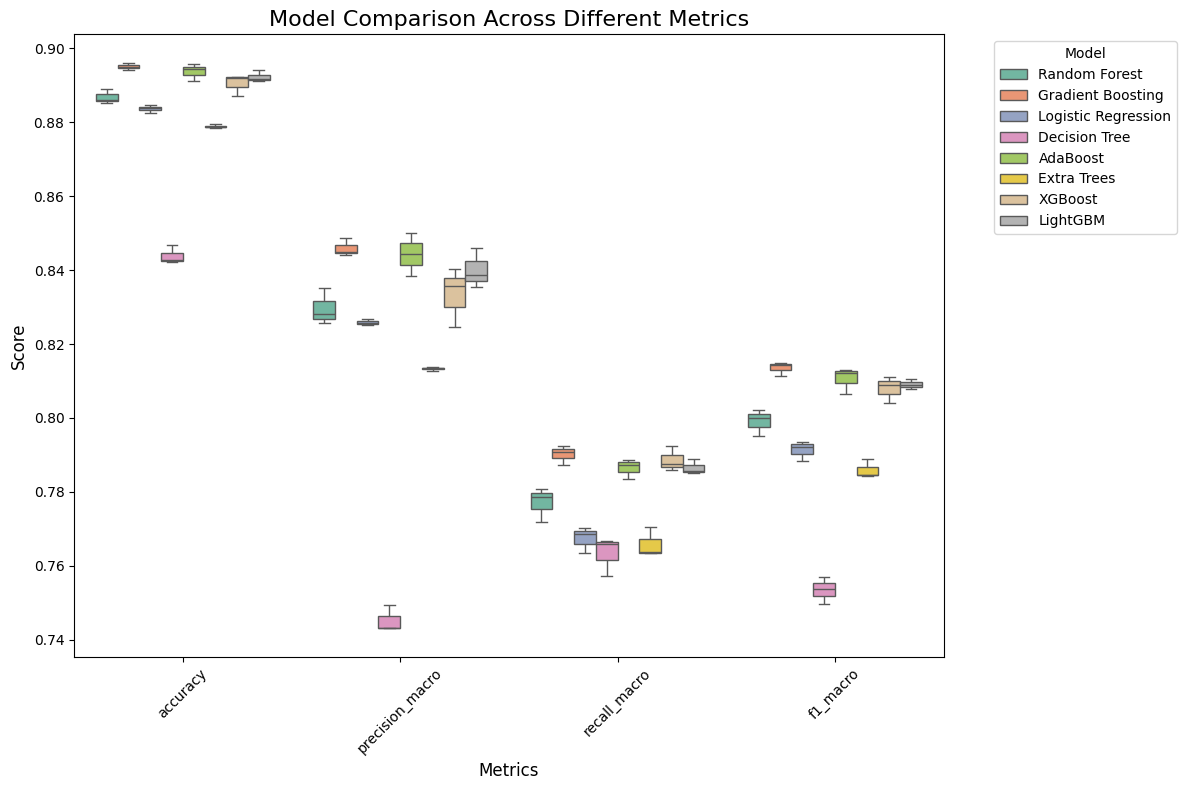

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Cross-validation results to store in a format suitable for boxplots
cv_results = {
    'model': [],
    'metric': [],
    'score': []
}

# Evaluate each model using cross-validation and store results for boxplots
for name, model in models.items():
    print(f"Evaluating {name}...")
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])

    # Cross-validation with sampling and parallel processing
    scores = cross_validate(
        pipeline,
        X_sampled,
        y_sampled,
        cv=3,  # 3-fold CV for speed
        scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro'],
        return_train_score=False,
        n_jobs=-1  # Parallel processing
    )

    # Collect the scores for each metric
    for metric in ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']:
        cv_results['model'].extend([name] * 3)  # 3 folds
        cv_results['metric'].extend([metric] * 3)  # 3 folds
        cv_results['score'].extend(scores[f'test_{metric}'])  # 3 fold scores

# Convert to DataFrame for easier plotting
cv_results_df = pd.DataFrame(cv_results)

# Set up the figure and axes
plt.figure(figsize=(12, 8))

# Create the boxplot
sns.boxplot(x='metric', y='score', hue='model', data=cv_results_df, palette='Set2')

# Set titles and labels
plt.title('Model Comparison Across Different Metrics', fontsize=16)
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()


In [20]:
print(results_df)

                     accuracy_mean  accuracy_std  precision_mean  \
Gradient Boosting          0.89500      0.000809        0.845858   
AdaBoost                   0.89370      0.001936        0.844350   
LightGBM                   0.89225      0.001314        0.840042   
XGBoost                    0.89035      0.002442        0.833478   
Random Forest              0.88675      0.001612        0.829563   
Logistic Regression        0.88360      0.000797        0.825879   
Extra Trees                0.87885      0.000397        0.813317   
Decision Tree              0.84380      0.002054        0.745312   

                     precision_std  recall_mean  recall_std   f1_mean  \
Gradient Boosting         0.001943     0.790176    0.002044  0.813566   
AdaBoost                  0.004743     0.786518    0.002162  0.810600   
LightGBM                  0.004458     0.786543    0.001597  0.809068   
XGBoost                   0.006640     0.788639    0.002677  0.807990   
Random Forest         

In [21]:
#Model pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42),)
])

In [22]:
#Train model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94     44897
           1       0.78      0.61      0.68     10229

    accuracy                           0.90     55126
   macro avg       0.85      0.78      0.81     55126
weighted avg       0.89      0.90      0.89     55126



In [23]:
#Function to estimate win probability based on character name
def estimate_character_win(character):
    if character not in average_stats.index:
        return f"Character {character} not found in the dataset."
    
    # Get the average stats for the given character
    avg_stats = average_stats.loc[character]
    
    # Prepare input for model prediction using average stats
    input_df = pd.DataFrame([{
        'character': character,
        'Kill': avg_stats['Kill'],
        'Death': avg_stats['Death'],
        'Assist': avg_stats['Assist'],
        'Dmg_Player': avg_stats['Dmg_Player']
    }])

    #Predict win probability using the model
    model_prob = model.predict_proba(input_df)[0][1]

    #Get historical win rate for the character
    historical_win_rate = win_rate.loc[character]

    #Combine model prediction with historical win rate (weighted average)
    combined_prob = 0.7 * model_prob + 0.3 * historical_win_rate  # Adjustable to

    #Calculate expected wins in 100 games
    expected_wins = combined_prob * 200

    return (
        f"Character: {character}\n"
        f"Model Win Probability: {model_prob:.2%}\n"
        f"Historical Win Rate: {historical_win_rate:.2%}\n"
        f"Expected Wins in 200 Games: {expected_wins:.1f}"
    )



In [28]:
# Example usage
print(estimate_character_win("Rio"))

Character: Rio
Model Win Probability: 6.83%
Historical Win Rate: 20.70%
Expected Wins in 200 Games: 22.0


In [29]:
df[df['character'] == 'Rio']['win'].value_counts()


win
0    4988
1    1302
Name: count, dtype: int64

In [32]:
importances = model.named_steps['classifier'].feature_importances_
feature_names = model.named_steps['preprocessor'].get_feature_names_out()
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)
print(feature_importance_df.head(10))


                           feature  importance
82               remainder__Assist    0.293336
83           remainder__Dmg_Player    0.277970
80                 remainder__Kill    0.147632
81                remainder__Death    0.142650
32           char__character_Hisui    0.003293
45           char__character_Katja    0.003057
77            char__character_Yuki    0.002983
20  char__character_Debi_&_Marlene    0.002963
8              char__character_Aya    0.002910
53            char__character_Luke    0.002814
